# Optimization of Transductive Conformal Predictors based on Naive Bayes Classifier via Incremental and Decremental Learning

This notebook documents our experiments about comparison of optimized Transductive Conformal Predictors (OTCP) based on different ML Methods. In addition to our OTCP based on MultinomialNB and GaussianNB, we also directly use OTCP based on KNN and KDE from Giovanni‘s paper.

We first implement the OTCP using MultinomialNB or GaussianNB. **Next, we directly copy the code about OTCP based on KNN and KDE from Giovanni‘s work.** Finally, we evaluate the training time and average prediction time and compare them.


The code in this notebook refers to some ideas from Giovanni‘s paper **Exact Optimization of Conformal Predictors via Incremental and Decremental Learning**, and use the utility class **eli.py** directly. You can find the paper, code and utility class in the link: https://github.com/gchers/exact-cp-optimization.

**Note**: Please read Giovanni‘s paper and code carefully first, and then look at the content below.

# Settings

## Multiprocessing Settings

In [1]:
# Disable multithreading in numpy for fair measurements.
# Needs to be run before importing numpy.
import os
import ctypes
def disable_np_multithreading():
    """A multithreading-disabling routine for numpy, taken
    from https://github.com/numpy/numpy/issues/11826.
    """
    try:
        import mkl
        mkl.set_num_threads(1)
        return 0
    except:
        pass

    for name in [ "libmkl_rt.so", "libmkl_rt.dylib", "mkl_Rt.dll"]:
        try:
            mkl_rt = ctypes.CDLL(name)
            mkl_rt.mkl_set_num_threads(ctypes.byref(ctypes.c_int(1)))
            return 0
        except:
            pass

    os.environ["OMP_NUM_THREADS"] = "1"
    os.environ["OPENBLAS_NUM_THREADS"] = "1"
    os.environ["MKL_NUM_THREADS"] = "1"
    os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
    os.environ["NUMEXPR_NUM_THREADS"] = "1"
disable_np_multithreading()

0

## Install Libraries

In [2]:
pip install sh

In [3]:
pip install arrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.2 MB/s eta 0:00:00


In [4]:
pip install setproctitle

In [5]:
pip install flatten-dict

In [6]:
pip install parameterized

##  Import Libraries

In [7]:
# Import class Eli from the separate utility class file 'eli.py'.
from eli import Eli
import copy
from sklearn.utils import resample
import math
import time
import random
import unittest
import matplotlib
import numpy as np
from numpy.linalg import inv
import pandas as pd
from collections import defaultdict
import seaborn as sns
from google.colab import files
import matplotlib.pylab as plt
from scipy.special import softmax
from sklearn import preprocessing
import matplotlib.ticker as ticker
from sklearn.datasets import load_iris
from parameterized import parameterized
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances, rbf_kernel

## Plots Settings

In [8]:
DPI = 300
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')
plt.style.use(['seaborn-v0_8-white', 'seaborn-v0_8-talk'])

# Definitions


## Functions


### dist

In [9]:
def dist(a, b):
    return euclidean_distances([a], [b])[0][0]

### best_k

In [10]:
def best_k(a, k):
    if len(a) <= k:
        return a

    return a[np.argpartition(a, k)[:k]]

### compute_pvalues

In [11]:
# Define a function to compute p-values for x and all candidate class labels given
# a nonconformity measure ncm.
def compute_pvalues(x, labels, ncm):
    pvalues_x = []
    for y in labels:
        score_x, scores = ncm.compute_scores(x, y)
        scores = np.array(scores)
        pvalue = (1 + sum(scores >= score_x)) / (1 + len(scores))
        pvalues_x.append(pvalue)

    return pvalues_x

### cp_predict

In [12]:
# Define a function to return p-values and running time for x and all candidate
# class labels given a nonconformity measure ncm.
def cp_predict(Xtrain, Ytrain, Xtest, labels, ncm, return_time=False, timeout=None):

    # Record training time.
    start = time.perf_counter()
    ncm.train(Xtrain, Ytrain)
    train_time = time.perf_counter() - start

    # Record p-values and cumulative prediction time for each x in Xtest.
    start = time.perf_counter()
    prediction_times = []
    reached_timeout = False
    pvalues = []
    for x in Xtest:
        pvalues_x = compute_pvalues(x, labels, ncm)
        pvalues.append(pvalues_x)

        # Store prediction time.
        t = time.perf_counter() - start
        prediction_times.append(t)

        # Check if reached timeout.
        if timeout and t > timeout:
            reached_timeout = True
            break

    if return_time:
        return np.array(pvalues), {"training_time": train_time,
                                   "prediction_time": prediction_times,
                                   "reached_timeout": reached_timeout,
                                   }
    else:
        return np.array(pvalues)

### evaluate_ncm

In [13]:
def evaluate_ncm(ncm, train_size, max_test_size, n_classes, n_dimensions,
                 inductive_cp, calibration_size, timeout, is_mnb = False):
    # Discard invalid parameter sets.
    if inductive_cp and calibration_size is None:
        return
    if not inductive_cp and calibration_size is not None:
        return

    ncm_class = eval(ncm)       # eval(): Perdoname, madre, por mi vida loca :D
    ncm = ncm_class()

    X, Y = make_classification(train_size+max_test_size,
                               n_dimensions, n_classes=n_classes, n_informative=10)

    # Bin continuous data into intervals by using KBinsDiscretizer from scikit-learn.
    if is_mnb:
      X = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform', random_state=0).fit_transform(X).astype(int)

    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=max_test_size)

    if inductive_cp:
        Xtrain, Xcalib, Ytrain, Ycalib = train_test_split(Xtrain, Ytrain,
                                                          test_size=calibration_size)
        _, times = icp_predict(Xtrain, Ytrain, Xcalib, Ycalib,
                               Xtest, np.unique(Y), ncm, return_time=True)
    else:
        _, times = cp_predict(Xtrain, Ytrain, Xtest, np.unique(Y),
                          ncm, return_time=True, timeout=timeout)

    return times

## Classes


### NCM

In [14]:
# Define a class for nonconformity measures.
class NCM:

  def name(self):
    return self.__class__.__name__

  # By default, this simply stores the training data as an element of the NCM object.
  def train(self, X, Y):
      self.X = np.array(X)
      self.Y = np.array(Y)

  # Should return the nonconformity scorer for the training data (X, Y), which is a
  # function (x, y) -> score
  def train_ncm(self, X, Y):
      def example_scorer(x, y):
          raise NotImplemented

      return example_scorer

  # Returns a tuple: (score_x, scores) where score_x is the score for (x, y) and
  # scores are the nonconformity scores for the training examples.
  def compute_scores(self, x, y, only_score_x = False):
    ncm = self.train_ncm(self.X, self.Y)
    score_x = ncm(x, y)

    # If `only_score_x = True`, this method returns only the score for (x, y).
    if only_score_x:
        return score_x

    scores = []

    for i in range(len(self.X)):

        # Score the i-th example, removing it from the training data set and appending (x, y) instead.
        idx = np.array(list(range(len(self.X))))
        ncm = self.train_ncm(np.row_stack((self.X[idx!=i,:], x)),np.append(self.Y[idx!=i], y))
        scores.append(ncm(self.X[i,:], self.Y[i]))

    return score_x, scores

### Optimized TCP using MultinomialNB (OTCPM)

In [15]:
# Define a class to implement Optimized Transductive Conformal Predictor using MultinomialNB.
# We overowrite the 'compute_scores' function using incremental and decremental learning.
class OTCPM(NCM):

  def __init__(self):
    self.X = np.array
    self.Y = np.array
    self.instance_num = int
    self.feature_num = int
    self.class_num = int
    self.value_max = int
    self.class_count = np.array
    self.value_count = np.array
    self.temporary_scores = np.array
    self.denominator_product = np.array

  # Define a function to fit the MultinomialNB on the training data X, Y
  # and store the result in 'self.class_count' and 'self.value_count'.
  def train(self, X, Y):
    self.X = X
    self.Y = Y
    self.instance_num = self.X.shape[0]
    self.feature_num = self.X.shape[1]
    self.class_num = np.unique(self.Y).shape[0]
    self.value_max = np.max(self.X)

    # Initialize the arrays 'self.class_count' and 'self.value_count'
    # and set the default value to be 0
    self.class_count = np.zeros(self.class_num)
    self.denominator_product = np.zeros(self.class_num)
    self.value_count = np.zeros((self.class_num, self.feature_num, self.value_max+1))
    self.temporary_scores = np.zeros(self.instance_num)

    # Fit the MultinomialNB on training data set and update the arrays
    # 'self.class_count' and 'self.value_count'.
    for x, y in zip(self.X, self.Y):
      self.class_count[y]+=1
      for f in np.arange(self.feature_num):
        self.value_count[y,f,x[f]]+=1

    # Here we use a trick for speedup by multiplying all the denominators ahead, and
    # store in 'self.denominator_product'.
    for y in np.arange(self.class_num):
      self.denominator_product[y] = self.instance_num * ((self.class_count[y])**self.feature_num)

    # Precompute the score when unlearning a training instance, and store in
    # 'self.temporary_scores'.
    for i, (x, y) in enumerate(zip(self.X, self.Y)):
      prior = (self.class_count[y] - 1) / (self.instance_num -1)
      likelihood = 1
      for f in np.arange(self.feature_num):
            likelihood *= (self.value_count[y,f,x[f]]-1) / (self.class_count[y] - 1)

      posterior = likelihood * prior
      self.temporary_scores[i]=posterior

  def compute_scores(self, x, y, only_score_x=False):

    # Calculate the prior class count 'prior'.
    prior = self.class_count[y]
    likelihood = 1

    # Calculate the likelihood count of each feature and multiply them together.
    for f in np.arange(self.feature_num):
        likelihood *= self.value_count[y,f,x[f]]

    # Calculate the final posterior probability for x.
    posterior = likelihood * prior / self.denominator_product[y]

    score_x = -posterior

    # If `only_score_x = True`, this method returns only the score for (x, y).
    if only_score_x:
      return score_x

    # Add the test instance (x,y) to 'self.value_count'.
    for f in np.arange(self.feature_num):
      self.value_count[y,f,x[f]] += 1

    scores = []

    # Compute score for each instance in the training data set.
    for i, (x_out, y_out) in enumerate(zip(self.X, self.Y)):
      if y==y_out:
        prior = self.class_count[y_out]
        likelihood = 1
        for f in np.arange(self.feature_num):
          likelihood *= (self.value_count[y_out,f,x_out[f]]-1)
        posterior = likelihood * prior / self.denominator_product[y]
        scores.append(-posterior)
      else:
        scores.append(-self.temporary_scores[i]*(self.instance_num-1)/self.instance_num)

    # Remove the test instance (x,y) from 'self.value_count'.
    for f in np.arange(self.feature_num):
      self.value_count[y,f,x[f]] -= 1

    return score_x, scores

### Optimized TCP using GaussianNB (OTCPG)

In [16]:
# Define a class to implement Optimized Transductive Conformal Predictor using MultinomialNB.
# But we overowrite the 'compute_scores' function using incremental and decremental learning.
class OTCPG(NCM):

  def __init__(self):
    self.X = np.array
    self.Y = np.array
    self.instance_num = int
    self.feature_num = int
    self.class_num = int
    self.class_count = np.array
    self.value_sum= np.array
    self.temporary_scores = np.array

  # Define a function to fit the GaussianNB on the training data X, Y
  # and store the result in 'self.class_count' and 'self.value_sum'.
  def train(self, X, Y):
    self.X = X
    self.Y = Y
    self.instance_num = self.X.shape[0]
    self.feature_num = self.X.shape[1]
    self.class_num = np.unique(self.Y).shape[0]

    # Initialize the arrays 'self.class_count' and 'self.value_sum'
    # and set the default value to be 0
    self.class_count = np.zeros(self.class_num)
    # The thrid dimension of 'self.value_sum' store the 'sum of value' and 'sum of squares of value',
    # '0' for 'sum of value' and '1' for 'sum of squares of value'.
    self.value_sum = np.zeros((self.class_num, self.feature_num, 2))
    self.temporary_scores = np.zeros(self.instance_num)

    # Fit the GaussianNB on training data set and update the arrays
    # 'self.class_count' and 'self.value_sum'.
    for x, y in zip(self.X, self.Y):
      self.class_count[y]+=1
      for f in np.arange(self.feature_num):
        self.value_sum[y,f,0]+=x[f]
        self.value_sum[y,f,1]+=x[f]**2

    # Precompute the score when unlearning a training instance, and store in
    # 'self.temporary_scores'.
    for i, (x, y) in enumerate(zip(self.X, self.Y)):
      prior = (self.class_count[y] - 1) / (self.instance_num -1)
      likelihood = 1

      for f in np.arange(self.feature_num):
        mean = (self.value_sum[y,f,0] - x[f]) / (self.class_count[y] - 1)
        var = (self.value_sum[y,f,1] - x[f]**2)/(self.class_count[y] - 1) - mean**2
        likelihood *= (1/np.sqrt(2*np.pi*var)) * np.exp(-(x[f] - mean)**2 / (2*var))

      posterior = likelihood * prior
      self.temporary_scores[i]=posterior

  def compute_scores(self, x, y, only_score_x=False):

    # Calculate the prior class probability 'prior'.
    prior = self.class_count[y] / self.instance_num
    likelihood = 1

    # Calculate the likelihood of each feature and multiply them together.
    for f in np.arange(self.feature_num):
      mean = self.value_sum[y,f,0] / self.class_count[y]
      var = self.value_sum[y,f,1] / self.class_count[y] - mean**2
      likelihood *= (1/np.sqrt(2*np.pi*var)) * np.exp(-(x[f] - mean)**2 / (2*var))

    # Calculate the final posterior probability for x.
    posterior = likelihood * prior

    score_x = -posterior

    # If `only_score_x = True`, this method returns only the prediction for (x, y).
    if only_score_x:
      return score_x

    # Add the test instance (x,y) to 'self.value_sum'.
    for f in np.arange(self.feature_num):
      self.value_sum[y,f,0] += x[f]
      self.value_sum[y,f,1] += x[f]**2

    scores = []

    # Compute score for each instance in the training data set.
    for i, (x_out, y_out) in enumerate(zip(self.X, self.Y)):
      if y==y_out:
        prior = self.class_count[y_out]  / self.instance_num
        likelihood = 1

        for f in np.arange(self.feature_num):
          mean = (self.value_sum[y_out,f,0] - x_out[f]) / self.class_count[y_out]
          var = (self.value_sum[y_out,f,1] - x_out[f]**2)/self.class_count[y_out] - mean**2
          likelihood *= (1/np.sqrt(2*np.pi*var)) * np.exp(-(x_out[f] - mean)**2 / (2*var))

        posterior = likelihood * prior
        scores.append(-posterior)
      else:
        scores.append(-self.temporary_scores[i]*(self.instance_num-1)/self.instance_num)

    # Remove the test instance (x,y) from 'self.value_sum'.
    for f in np.arange(self.feature_num):
      self.value_sum[y,f,0] -= x[f]
      self.value_sum[y,f,1] -= x[f]**2

    return score_x, scores

### KNN

In [17]:
class KNN_fast(NCM):
    def __init__(self, k=15):
        self.k = k

    def train(self, X, Y):
        # k best distances from y and from not y for each training point.
        self.distances_y = []
        self.distances_not_y = []
        self.temporary_scores = []

        for x, y, all_dist in zip(X, Y, euclidean_distances(X)):
            # Keep smallest k distances (excluding "self").
            kdist_y = sorted(all_dist[Y==y])[1:self.k+1]
            kdist_not_y = sorted(all_dist[Y!=y])[:self.k]
            score = sum(kdist_y) / sum(kdist_not_y)

            self.distances_y.append(kdist_y)
            self.distances_not_y.append(kdist_not_y)
            self.temporary_scores.append(score)

        self.X = X
        self.Y = Y

    def compute_scores(self, x, y, only_score_x=False):
        # Score the new example first.
        distances_x = euclidean_distances([x], self.X).flatten()

        # Best k for y and not y.
        kdist_y = best_k(distances_x[self.Y==y], self.k)
        kdist_not_y = best_k(distances_x[self.Y!=y], self.k)

        score_x = sum(kdist_y) / max(sum(kdist_not_y), 0.1)

        if only_score_x:
            return score_x

        # Compute the remaining scores.
        scores = []

        for dist_x, kdist_y, kdist_not_y, score, yi in zip(distances_x,
                                                           self.distances_y,
                                                           self.distances_not_y,
                                                           self.temporary_scores,
                                                           self.Y):
            if yi == y:
                # dist_x affects the score's nominator if its label
                # is yi, the denominator otherwise.
                if len(kdist_y) < self.k or kdist_y[-1] > dist_x:
                    # Remove effect of dist_y[-1] and use new distance.
                    # NOTE: write "kdist_y[:self.k-1]" and not "kdist_y[:-1]"
                    # or the code will have issues when dealing with small
                    # training sets (and train objects don't have k neighbors).
                    score = (score / sum(kdist_y)) * (sum(kdist_y[:self.k-1]) + dist_x)
            else:
                if len(kdist_not_y) < self.k or kdist_not_y[-1] > dist_x:
                    score = (score * sum(kdist_not_y)) / (sum(kdist_not_y[:self.k-1]) + dist_x)

            scores.append(score)

        return score_x, np.array(scores)

### KDE

In [18]:
class KDE_fast(NCM):
    def __init__(self, h=1.):
        self.h = h

    def train(self, X, Y):
        scores = {}
        mult_factor = {}

        for y in set(Y):
            Xy = X[Y==y, :]
            ny, d = Xy.shape
            dist_squared = euclidean_distances(Xy, squared=True)
            K = np.exp(-.5*dist_squared)
            # Remove contribution of distance to self.
            K -= np.eye(ny)
            # Precompute temporary scores and multiplicative factors.
            scores[y] = np.sum(K, axis=0)

            mult_factor[y] = -(2*np.pi)**(-.5*d)/((ny-1)*self.h**d)

        self.X = X
        self.Y = Y
        self.temporary_scores = scores
        self.mult_factor = mult_factor

    def compute_scores(self, x, y, only_score_x=False):
        # Preprocess kernel and compute score for (x, y).
        Xy = self.X[self.Y==y,:]
        dist_squared_y = euclidean_distances([x],
                                             Xy,
                                             squared=True).flatten()
        K = np.exp(-.5*dist_squared_y)

        # Update multiplicative factor.
        ny, d = Xy.shape
        mult_factor_y = self.mult_factor[y] * ((ny-1)*self.h**d)/(ny*self.h**d)

        # Compute the score for x.
        score_x = sum(K)*mult_factor_y

        if only_score_x:
            return score_x

        scores = []
        for yi, scores_yi in self.temporary_scores.items():
            if yi == y:
                # Update scores with example (x, y).
                scores_yi = scores_yi + K
                mult_factor = mult_factor_y
            else:
                mult_factor = self.mult_factor[yi]

            scores += list(scores_yi*mult_factor)

        # NOTE: can be further sped up by keeping track of the log-likelihood
        # instead of normal likelihood.
        return -np.log(-score_x), -np.log(-np.array(scores))

# Computational performance comparison


## Experiment

### Set Up Parameters

In [ ]:
EXPERIMENT_NAME = "training-size-comparison"
RESULTS_DIR = "results/"
REPETITIONS = 2
TRAIN_SIZE = np.logspace(2, 4.4, 10, dtype='int').tolist()
MAX_TEST_SIZE = 10
N_CLASSES = [10]
N_DIMENSIONS = 30
TIMEOUT = 60*60*10

### Comparison among Optimized TCPs

In [ ]:
eli = Eli(RESULTS_DIR)
eli.run_experiment(exp_name=EXPERIMENT_NAME,
                   func=evaluate_ncm,
                   repetitions=REPETITIONS,
                   n_jobs=40,
                   automatic_seed=True,
                   # Parameters
                   ncm="OTCPM",
                   train_size=TRAIN_SIZE,
                   max_test_size=MAX_TEST_SIZE,
                   n_classes=N_CLASSES,
                   n_dimensions=N_DIMENSIONS,
                   timeout=TIMEOUT,
                   calibration_size = None,
                   inductive_cp =False,
                   is_mnb = True
                  )

Running: results/training-size-comparison/ncm=OTCPM-train_size=341-max_test_size=10-n_classes=10-n_dimensions=30-timeout=36000-calibration_size=None-inductive_cp=False-is_mnb=True/0.jsonRunning: results/training-size-comparison/ncm=OTCPM-train_size=7356-max_test_size=10-n_classes=10-n_dimensions=30-timeout=36000-calibration_size=None-inductive_cp=False-is_mnb=True/0.jsonRunning: results/training-size-comparison/ncm=OTCPM-train_size=3981-max_test_size=10-n_classes=10-n_dimensions=30-timeout=36000-calibration_size=None-inductive_cp=False-is_mnb=True/1.jsonRunning: results/training-size-comparison/ncm=OTCPM-train_size=1165-max_test_size=10-n_classes=10-n_dimensions=30-timeout=36000-calibration_size=None-inductive_cp=False-is_mnb=True/0.jsonRunning: results/training-size-comparison/ncm=OTCPM-train_size=630-max_test_size=10-n_classes=10-n_dimensions=30-timeout=36000-calibration_size=None-inductive_cp=False-is_mnb=True/1.json




Running: results/training-size-comparison/ncm=OTCPM-train_size

In [ ]:
eli = Eli(RESULTS_DIR)
eli.run_experiment(exp_name=EXPERIMENT_NAME,
                   func=evaluate_ncm,
                   repetitions=REPETITIONS,
                   n_jobs=40,
                   automatic_seed=True,
                   # Parameters
                   ncm="OTCPG",
                   train_size=TRAIN_SIZE,
                   max_test_size=MAX_TEST_SIZE,
                   n_classes=N_CLASSES,
                   n_dimensions=N_DIMENSIONS,
                   timeout=TIMEOUT,
                   calibration_size = None,
                   inductive_cp = False,
                   is_mnb = True
                  )

Running: results/training-size-comparison/ncm=OTCPG-train_size=25118-max_test_size=10-n_classes=10-n_dimensions=30-timeout=36000-calibration_size=None-inductive_cp=False-is_mnb=True/1.jsonRunning: results/training-size-comparison/ncm=OTCPG-train_size=7356-max_test_size=10-n_classes=10-n_dimensions=30-timeout=36000-calibration_size=None-inductive_cp=False-is_mnb=True/0.json

Running: results/training-size-comparison/ncm=OTCPG-train_size=13593-max_test_size=10-n_classes=10-n_dimensions=30-timeout=36000-calibration_size=None-inductive_cp=False-is_mnb=True/1.jsonRunning: results/training-size-comparison/ncm=OTCPG-train_size=25118-max_test_size=10-n_classes=10-n_dimensions=30-timeout=36000-calibration_size=None-inductive_cp=False-is_mnb=True/0.jsonRunning: results/training-size-comparison/ncm=OTCPG-train_size=1165-max_test_size=10-n_classes=10-n_dimensions=30-timeout=36000-calibration_size=None-inductive_cp=False-is_mnb=True/1.json
Running: results/training-size-comparison/ncm=OTCPG-train_s

In [ ]:
eli = Eli(RESULTS_DIR)
eli.run_experiment(exp_name=EXPERIMENT_NAME,
                   func=evaluate_ncm,
                   repetitions=REPETITIONS,
                   n_jobs=40,
                   automatic_seed=True,
                   # Parameters
                   ncm="KNN_fast",
                   train_size=TRAIN_SIZE,
                   max_test_size=MAX_TEST_SIZE,
                   n_classes=N_CLASSES,
                   n_dimensions=N_DIMENSIONS,
                   timeout=TIMEOUT,
                   calibration_size = None,
                   inductive_cp = False,
                   is_mnb = True
                  )

In [ ]:
eli = Eli(RESULTS_DIR)
eli.run_experiment(exp_name=EXPERIMENT_NAME,
                   func=evaluate_ncm,
                   repetitions=REPETITIONS,
                   n_jobs=40,
                   automatic_seed=True,
                   # Parameters
                   ncm="KDE_fast",
                   train_size=TRAIN_SIZE,
                   max_test_size=MAX_TEST_SIZE,
                   n_classes=N_CLASSES,
                   n_dimensions=N_DIMENSIONS,
                   timeout=TIMEOUT,
                   calibration_size = None,
                   inductive_cp = False,
                   is_mnb = True
                  )

Running: results/training-size-comparison/ncm=KDE_fast-train_size=341-max_test_size=10-n_classes=10-n_dimensions=30-timeout=36000-calibration_size=None-inductive_cp=False-is_mnb=True/0.json
Running: results/training-size-comparison/ncm=KDE_fast-train_size=100-max_test_size=10-n_classes=10-n_dimensions=30-timeout=36000-calibration_size=None-inductive_cp=False-is_mnb=True/0.jsonRunning: results/training-size-comparison/ncm=KDE_fast-train_size=184-max_test_size=10-n_classes=10-n_dimensions=30-timeout=36000-calibration_size=None-inductive_cp=False-is_mnb=True/0.json

Running: results/training-size-comparison/ncm=KDE_fast-train_size=100-max_test_size=10-n_classes=10-n_dimensions=30-timeout=36000-calibration_size=None-inductive_cp=False-is_mnb=True/1.jsonRunning: results/training-size-comparison/ncm=KDE_fast-train_size=2154-max_test_size=10-n_classes=10-n_dimensions=30-timeout=36000-calibration_size=None-inductive_cp=False-is_mnb=True/1.jsonRunning: results/training-size-comparison/ncm=KDE_f

## Results

In [ ]:
# Load result data
eli = Eli(RESULTS_DIR)
results = eli.fetch_results("training-size-comparison")

# Define a function to return the average prediction time for each
# observation and store it in 'avg_time'.
avgerage_time = lambda vec: np.concatenate(([vec[0]], pd.Series(vec).diff()[1:])).mean()
results["avg_time"] = results.prediction_time.apply(avgerage_time)

print(f"{len(results)} observations")
results.head()

80 observations


,name,training_time,prediction_time,reached_timeout,ncm,train_size,max_test_size,n_classes,n_dimensions,timeout,calibration_size,inductive_cp,is_mnb,repetition,git-commit,started,finished,avg_time
0,ncm=KNN_fast-train_size=1165-max_test_size=10-...,9.174170,"[0.6197636300003069, 1.1274805230004858, 1.622...",False,KNN_fast,1165,10,10,30,36000,None,False,True,1,no-git-repo,2023-07-03T16:35:59.961114+00:00,2023-07-03T16:36:14.978781+00:00,0.544562
1,ncm=KNN_fast-train_size=1165-max_test_size=10-...,9.433083,"[0.6662860399992496, 1.2196549919990503, 1.889...",False,KNN_fast,1165,10,10,30,36000,None,False,True,0,no-git-repo,2023-07-03T16:35:59.911932+00:00,2023-07-03T16:36:15.476963+00:00,0.571218
2,ncm=OTCPG-train_size=630-max_test_size=10-n_cl...,2.843308,"[2.903125201999501, 5.645400607001648, 9.11732...",False,OTCPG,630,10,10,30,36000,None,False,True,1,no-git-repo,2023-07-03T18:19:10.171460+00:00,2023-07-03T18:19:39.785778+00:00,2.665404
3,ncm=OTCPG-train_size=630-max_test_size=10-n_cl...,3.036842,"[2.8792139629986195, 5.502180029001465, 9.2795...",False,OTCPG,630,10,10,30,36000,None,False,True,0,no-git-repo,2023-07-03T18:19:10.200060+00:00,2023-07-03T18:19:40.757154+00:00,2.730799
4,ncm=KDE_fast-train_size=25118-max_test_size=10...,19.955340,"[9.359836929999915, 13.604593651999949, 17.055...",False,KDE_fast,25118,10,10,30,36000,None,False,True,1,no-git-repo,2023-07-04T08:07:37.317153+00:00,2023-07-04T08:08:33.915453+00:00,3.463214


In [ ]:
MAX_TRAIN_SIZE = max(TRAIN_SIZE)
MAX_CLASS_SIZE = max(N_CLASSES)

print("MultinomialNB (train: {} test: {} class size:{}): \n\t Training Time: {} seconds \n\t Average Prediction Time: {} seconds\n".format(
    MAX_TRAIN_SIZE,
    MAX_TEST_SIZE,
    MAX_CLASS_SIZE,
    results[(results.ncm=="OTCPM") & (results.train_size==MAX_TRAIN_SIZE) & (results.n_classes==MAX_CLASS_SIZE)].training_time.mean(),
    results[(results.ncm=="OTCPM") & (results.train_size==MAX_TRAIN_SIZE) & (results.n_classes==MAX_CLASS_SIZE)].avg_time.mean()
))

print("GaussianNB (train: {} test: {} class size:{}): \n\t Training Time: {} seconds \n\t Average Prediction Time: {} seconds\n".format(
    MAX_TRAIN_SIZE,
    MAX_TEST_SIZE,
    MAX_CLASS_SIZE,
    results[(results.ncm=="OTCPG") & (results.train_size==MAX_TRAIN_SIZE) & (results.n_classes==MAX_CLASS_SIZE)].training_time.mean(),
    results[(results.ncm=="OTCPG") & (results.train_size==MAX_TRAIN_SIZE) & (results.n_classes==MAX_CLASS_SIZE)].avg_time.mean()
))

print("k-NN (train: {} test: {} class size:{}): \n\t Training Time: {} seconds \n\t Average Prediction Time: {} seconds\n".format(
    MAX_TRAIN_SIZE,
    MAX_TEST_SIZE,
    MAX_CLASS_SIZE,
    results[(results.ncm=="KNN_fast") & (results.train_size==MAX_TRAIN_SIZE) & (results.n_classes==MAX_CLASS_SIZE)].training_time.mean(),
    results[(results.ncm=="KNN_fast") & (results.train_size==MAX_TRAIN_SIZE) & (results.n_classes==MAX_CLASS_SIZE)].avg_time.mean()
))

print("KDE (train: {} test: {} class size:{}): \n\t Training Time: {} seconds \n\t Average Prediction Time: {} seconds".format(
    MAX_TRAIN_SIZE,
    MAX_TEST_SIZE,
    MAX_CLASS_SIZE,
    results[(results.ncm=="KDE_fast") & (results.train_size==MAX_TRAIN_SIZE) & (results.n_classes==MAX_CLASS_SIZE)].training_time.mean(),
    results[(results.ncm=="KDE_fast") & (results.train_size==MAX_TRAIN_SIZE) & (results.n_classes==MAX_CLASS_SIZE)].avg_time.mean()
))


MultinomialNB (train: 25118 test: 10 class size:10): 
	 Training Time: 15.506237990000955 seconds 
	 Average Prediction Time: 4.249614701200153 seconds

GaussianNB (train: 25118 test: 10 class size:10): 
	 Training Time: 80.06723463750131 seconds 
	 Average Prediction Time: 22.347054911899978 seconds

k-NN (train: 25118 test: 10 class size:10): 
	 Training Time: 348.1999729140007 seconds 
	 Average Prediction Time: 1.9930625134500586 seconds

KDE (train: 25118 test: 10 class size:10): 
	 Training Time: 20.133504280500006 seconds 
	 Average Prediction Time: 3.4810179247999997 seconds


## Plots

### Training Time

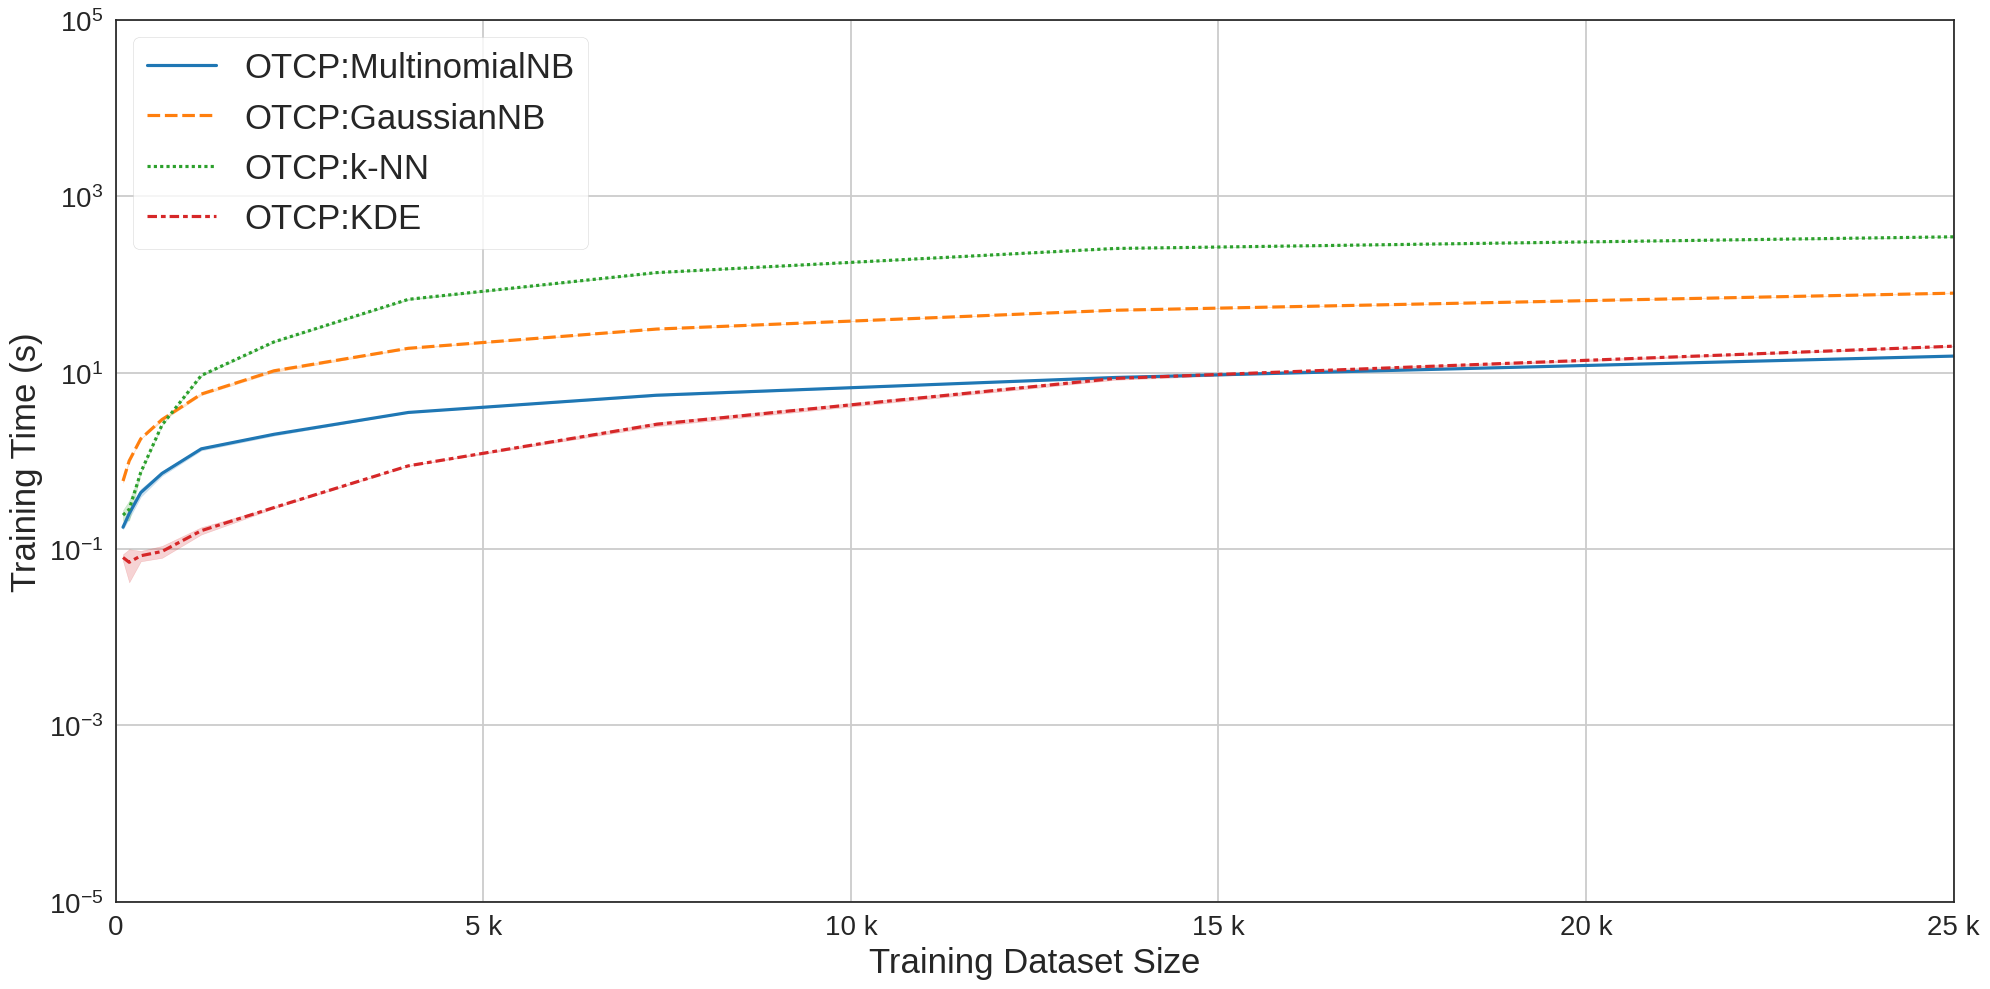

In [ ]:
NAMES = {"OTCPM": "OTCP:MultinomialNB",
         "OTCPG": "OTCP:GaussianNB",
         "KNN": "OTCP:k-NN",
         "KDE": "OTCP:KDE"
        }
NCM_SORTED = ["OTCPM",
              "OTCPG",
              "KNN",
              "KDE"
              ]

fig, ax = plt.subplots(figsize=(20, 10))

plot_data = results

# Sort labels
plot_data.ncm = [ncm.replace("_fast", "") for ncm in plot_data.ncm]
plot_data.ncm = pd.Categorical(plot_data.ncm, NCM_SORTED)
plot_data = plot_data.sort_values("ncm")

# Replace with nice names
plot_data.ncm = plot_data.ncm.apply(lambda ncm: NAMES[ncm])

# print(plot_data)

g = sns.lineplot(x="train_size", y="training_time", data=plot_data,
             hue="ncm", style="ncm", ax=ax)

# Remove legend title.
g.legend_.set_title(None)
g.legend_.set_frame_on(True)

ax.tick_params(axis='both',labelsize=20)
ax.set_yscale("log")
ax.set_xlim([0, 25000])
ax.set_ylim([10**-5, 10**5])
ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.set_xlabel("Training Dataset Size", fontsize=25)
ax.set_ylabel("Training Time (s)", fontsize=25)
ax.legend(title="", loc="best", frameon=True, fontsize=25)
ax.grid()

fig.tight_layout()

### Average Prediction Time

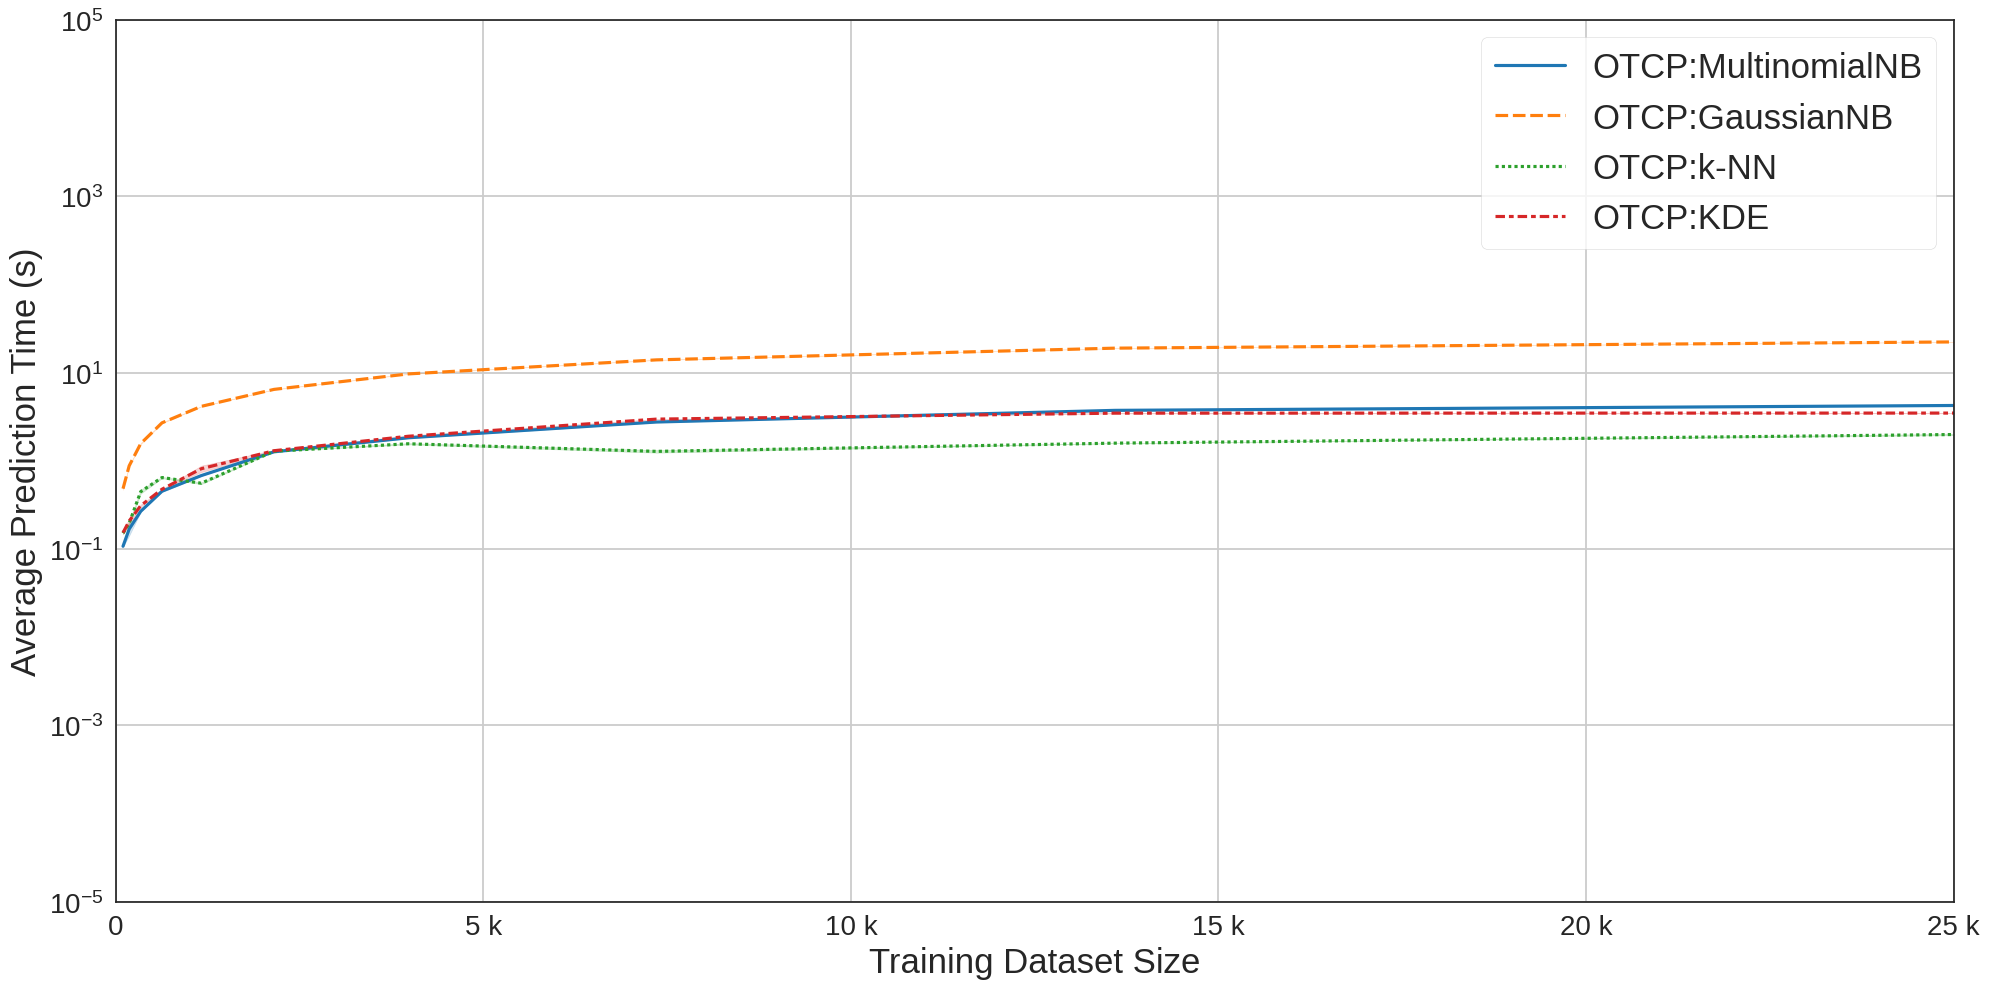

In [ ]:
NAMES = {"OTCPM": "OTCP:MultinomialNB",
         "OTCPG": "OTCP:GaussianNB",
         "KNN": "OTCP:k-NN",
         "KDE": "OTCP:KDE"
        }
NCM_SORTED = ["OTCPM",
              "OTCPG",
              "KNN",
              "KDE"
              ]

fig, ax = plt.subplots(figsize=(20, 10))

plot_data = results

# Sort labels
plot_data.ncm = [ncm.replace("_fast", "") for ncm in plot_data.ncm]
plot_data.ncm = pd.Categorical(plot_data.ncm, NCM_SORTED)
plot_data = plot_data.sort_values("ncm")

# Replace with nice names
plot_data.ncm = plot_data.ncm.apply(lambda ncm: NAMES[ncm])

# print(plot_data)

g = sns.lineplot(x="train_size", y="avg_time", data=plot_data,
             hue="ncm", style="ncm", ax=ax)

# Remove legend title.
g.legend_.set_title(None)
g.legend_.set_frame_on(True)

ax.tick_params(axis='both',labelsize=20)
ax.set_yscale("log")
ax.set_xlim([0, 25000])
ax.set_ylim([10**-5, 10**5])
ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.set_xlabel("Training Dataset Size", fontsize=25)
ax.set_ylabel("Average Prediction Time (s)",fontsize=25)
ax.legend(title="", loc="best", frameon=True, fontsize=25)
ax.grid()

fig.tight_layout()
